# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов и поучаствовать в соревновании на Kaggle!
Первым делом вам предстоит построить хороший бейзлайн, а дальше пытаться улучшать, соревнуясь с другими участниками.


Ссылка на соревнование: https://www.kaggle.com/c/avito-category-prediction/overview
Данные для домашнего задания можно скачать на странице соревнования.
Чтобы ваше участие было засчитано, убедитесь, что имя в Leaderboard имеет вид: «Имя Фамилия номер_группы».

Оценивание:

Домашнее задание оценивается как обычно. Баллы указаны напротив заданий.

За соревнование даются бонусные баллы следующим образом.
Если вы пересекли baseline_2 на приватном лидерборде, ваша оценка равна 

10 - 10 * (i - 1) / M

где M — количество студентов, принявших участие в соревновании;

i — место (начиная с 1) студента в приватном лидерборде среди всех таких студентов.

Правила:

* Домашнее задание оценивается в 10 баллов.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

* В течение 3 суток после окончания соревнования в соответствующее задание на anytask необходимо прислать код, воспроизводящий ответы для посылки, фигурирующей в приватном лидерборде. В случае отсутствия кода, воспроизводящего результат, в установленный срок студенту выставляется 0 в качестве оценки за соревнование. Если не оговорено иное, использовать любые внешние данные в соревнованиях '''запрещено'''. Под внешними данными понимаются размеченные данные, где разметка имеет прямое отношение к решаемой задаче. Грубо говоря, сборник текстов с википедии не считается внешними данными.


Мы будем работать с датасетом объявлений Avito. Нам предстоит по заголовку и тексту объявления предсказывать категорию объявления.

In [30]:
import pandas as pd
import numpy as np
np.random.seed(1)

import nltk
from nltk.corpus import stopwords
import string
nltk.download('stopwords')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,  HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ilya\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [2]:
%%time
train = pd.read_csv(r'avito-text-classification/train.csv')
test = pd.read_csv(r'avito-text-classification/test.csv')

In [3]:
train.head()

,title,description,Category_name,Category
0,"Эбу Renault / Nissan 1,5 DCI Delphi 2001-2008 год","Комплект ЭБУ (мозги, компьютер мотора, двигате...",Запчасти и аксессуары,10
1,Утюг утп 1000 ватт СССР 1987 год,Продам/\n Фото № 1-2 /\n /\nУтюг УТП 1000 ватт...,Бытовая техника,21
2,Возвму машину с выкупом,Возьму машину в аренду с последующим выкупом н...,Предложение услуг,114
3,Полусапожки,"полусапожки в отличном состоянии, один раз оде...","Одежда, обувь, аксессуары",27
4,Босоножки кожаные,"Кожаные(натур) босоножки Karlo Pasolini, 40 рр...","Одежда, обувь, аксессуары",27


In [4]:
test.head()

,title,description,itemid
0,Мастерка,Мастерка фирмы форвард. Белого цвета. В идеаль...,1778449823
1,Зимние сапоги,"Продаю зимние сапоги, в хорошем состоянии, все...",1677656962
2,Видеонаблюдение 8 камер,В комплект Atis AMD-2MIR-8kit входит: /\n1. Ку...,1758182804
3,Запчасти для GLE,Запчасти GLE,1689811299
4,Бластер nerf,Состояние 5+/\nПродаю потому что не нужен/\n18...,1804706240


In [5]:
train.shape

(4234042, 4)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [6]:
train.isnull().sum()

title            0
description      2
Category_name    0
Category         0
dtype: int64

In [7]:
test.isnull().sum()

title          0
description    1
itemid         0
dtype: int64

In [8]:
train['description'].fillna('', inplace = True)
train.isnull().sum()

title            0
description      0
Category_name    0
Category         0
dtype: int64

In [9]:
test['description'].fillna('', inplace = True)
test.isnull().sum()

title          0
description    0
itemid         0
dtype: int64

## Задание 2 (0.5 балла)
Сконкатенируйте заголовок и описание в единую строку и поместите результат в отдельный столбец. Таким образом мы будет работать с одним текстом, а не с двумя.

In [10]:
test['description'] = test.title + " " +  test.description
train['description'] = train.title + " " +  train.description

In [11]:
test.drop(columns='title', inplace = True)
train.drop(columns='title', inplace = True)

In [12]:
train.head()

,description,Category_name,Category
0,"Эбу Renault / Nissan 1,5 DCI Delphi 2001-2008 ...",Запчасти и аксессуары,10
1,Утюг утп 1000 ватт СССР 1987 год Продам/\n Фот...,Бытовая техника,21
2,Возвму машину с выкупом Возьму машину в аренду...,Предложение услуг,114
3,"Полусапожки полусапожки в отличном состоянии, ...","Одежда, обувь, аксессуары",27
4,Босоножки кожаные Кожаные(натур) босоножки Kar...,"Одежда, обувь, аксессуары",27


## Задание 3 (0.5 балла)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Сколько всего уникальных классов необходимо предсказать?
2. Постройте столбчатую диаграмму распределения по классам. Нормализуйте график, чтобы видеть доли, а не абсолютные значения.
3. На сколько большой дисбаланс? Какой класс имеет самую большую долю в выборке (укажите класс и долю), какой класс наименьшую (укажите класс и долю).

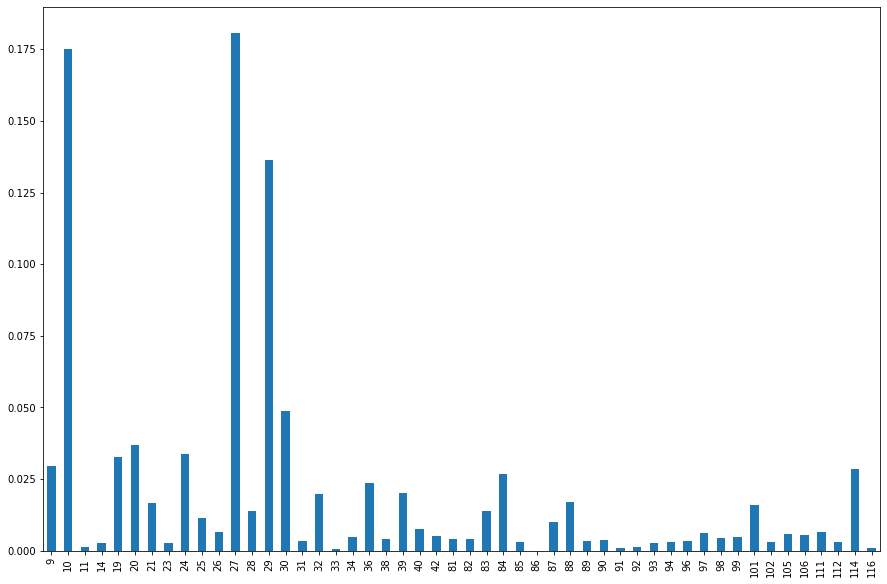

In [13]:
plt.figure(figsize = (15, 10))
classes = train['Category'].value_counts(normalize=True, sort = False)
a = classes.index.tolist()
b = classes.values.tolist()
classes.plot.bar()
plt.show()

In [14]:
ArgMax= np.argmax(b)
ArgMin= np.argmin(b)
print('max:', train[train['Category'] == a[ArgMax]]['Category_name'].unique(), a[ArgMax], b[ArgMax])
print('min:', train[train['Category'] == a[ArgMin]]['Category_name'].unique(), a[ArgMin], b[ArgMin])

max: ['Одежда, обувь, аксессуары'] 27 0.1807067572782698
min: ['Недвижимость за рубежом'] 86 3.8969854337769914e-05


Дисбаланс довольно большой. Имеется несколько больших категорий, которые имеют долю порядка 0.1-0.2, что отличается на 4 порядка от самого маленького класса

## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью. Для test части нам неизвестны истинные значения, и они понадобятся только тогда, когда мы будем отправлять решение на Kaggle.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [16]:
%%time 
count_vect = CountVectorizer()
train_counts = count_vect.fit_transform(train["description"])
train_counts.shape

Wall time: 4min 54s


(4234042, 2125805)

## Задание 5 (0.5 балла)

В предыдущем пункте у вас должная была получится очень большая матрица. Это не дело.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле _vocabulary инстанса этого класса.

1. Найдите в этом словаре все слова, которые начинаются на цифру. Сколько таких слов нашлось?

2. Найдите все слова, которые начинаются на символы пунктуации. Сколько таких слов нашлось? 

In [17]:
%%time
num, let = 0, 0
for i in count_vect.vocabulary_:
    if (i[0].isnumeric()):
        num += 1
    if (i[0] in string.punctuation):
        let += 1
print("С цифры начинается: ", num, 'слов')
print("С символов пунктуации начинается: ", let, 'слов')

С цифры начинается:  610956 слов
С буквы начинается:  2043 слов
Wall time: 696 ms


## Задание 6 (2.5 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью word_tokenizer из пакета nltk
2. Удалит все токены содержащие числа и пунктуацию
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords('russian')
4. Проведет стемминг с помощью SnowballStemmer

Продемонстрируйте работу вашей функии на самом первом описании товара в датасете.

Важно: так как функию будет необходимо запускать на большом корпусе, подумайте об эффективной реализации. Постарайтесь решить задачу в минимальное количество циклов и копирований.

Референсная реализация на компьютере автора работала 230 секунд на 100к строчек.

In [38]:
def preprocessor(data):
    return(np.char.lower(data))
def tokenizer_prep(data):
    stop_words = set(stopwords.words("russian"))
    return [x for x in nltk.word_tokenize(str(data)) if not ((x in stop_words) or (x[0] in string.punctuation) or (x[0].isnumeric()))]
def tokenizer(data):
    stemmer = SnowballStemmer('russian')
    data = (stemmer.stem(data) for data in tokenizer_prep(data))
    return data

## Задание 7 (1 балл)

1. Возьмите случайные 500к строк из датасета. Постройте по ним CountVectorizer с применением вашего токенизатора.
2. Разбейте полученную матрицу на train, test в отношении 4 к 1. Не забудьте про target переменную.
3. Обучите SGDClassifier на полученной выборке.
4. Посчитайте метрику accuracy

In [19]:
%%time
X = train.sample(n=500000, random_state=1)

In [ ]:
%%time 
count_vect_v2 = CountVectorizer(preprocessor=preprocessor, tokenizer=tokenizer)
X_counts = count_vect_v2.fit_transform(X["description"])
print(X_counts.shape)

In [ ]:
%%time
y = X["Category"]
X_train, X_test, y_train, y_test = train_test_split(X_counts, y, test_size=0.8, random_state=1)
classifier1 = SGDClassifier()
classifier1.fit(X_train, y_train)
print("На трейне:", accuracy_score(y_train, classifier1.predict(X_train)))
print("На тесте:", accuracy_score(y_test, classifier1.predict(X_test)))

## Задание 8 (1 балл)

1. Повторите 7 задание, но с tf-idf векторизатором. Как изменилось качество.
2. Мы можем еще сильнее уменьшите размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [ ]:
%%time
vect_v3 = TfidfVectorizer(preprocessor=preprocessor, tokenizer=tokenizer)
X_counts = vect_v3.fit_transform(X["description"])
print(X_counts.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_counts, y, test_size=0.8, random_state=1)
classifier2 = SGDClassifier()
classifier2.fit(X_train, y_train)
print("На трейне:", accuracy_score(y_train, classifier2.predict(X_train)))
print("На тесте:", accuracy_score(y_test, classifier2.predict(X_test)))

In [ ]:
%%time 
vect_v4 = TfidfVectorizer(max_df=0.9, preprocessor=preprocessor, tokenizer=tokenizer)
X_counts = vect_v4.fit_transform(X["description"])
print(X_counts.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_counts, y, test_size=0.8, random_state=1)
classifier3 = SGDClassifier()
classifier3.fit(X_train, y_train)
print("На трейне:", accuracy_score(y_train, classifier3.predict(X_train)))
print("На тесте:", accuracy_score(y_test, classifier3.predict(X_test)))

## Задание 9 (1 балл)
Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 7 с HashingVectorizer, укажите количество фичей равное 30000.
2. Какой из трех подходов показал самый высокий результат?

In [ ]:
%%time
vect_v5 = HashingVectorizer(n_features=30000, preprocessor=preprocessor, tokenizer=tokenizer)
X_counts = vect_v5.fit_transform(X["description"])
print(X_counts.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_counts, y, test_size=0.8, random_state=1)
classifier4 = SGDClassifier()
classifier4.fit(X_train, y_train)
print("На трейне:", accuracy_score(y_train, classifier4.predict(X_train)))
print("На тесте:", accuracy_score(y_test, classifier4.predict(X_test)))

## Задание 10 (1.5 балла)

Пришло время выйти в мир. Отправляйтесь на Kaggle Inclass и сделайте первую посылку. Там вы найдете инструкцию как сформировать файл с предсказаниями и отправить его.